In [184]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [185]:
def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

def show_points(coords, labels, ax, marker_size=150):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))   

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image) 

def convert_mask_to_orig_dims(cropped_mask, orig_img, crop_xmin, crop_ymin, crop_xmax, crop_ymax):
    orig_mask = np.zeros_like(orig_img[:, :, 0], dtype=np.uint8)
    orig_mask[crop_ymin:crop_ymax, crop_xmin:crop_xmax] = cropped_mask
    return orig_mask

In [186]:
TRAY_HSV_LOWER_BOUND = (85, 40, 20)
TRAY_HSV_UPPER_BOUND = (130, 255, 255)

BREAD_HSV_LOWER_BOUND = (10, 50, 100)
BREAD_HSV_UPPER_BOUND = (40, 255, 255)

TRAY_BOX_PIX = (
    250,
    20,
    630,
    350,
)  # (x1, y1, x2, y2) coordinates of the tray box in the image

In [187]:
first_img_path = "/home/parth/snaak/data/SCH_images_041125/cheese_check_1/image_20250411-150254.png"
second_img_path = "/home/parth/snaak/snaak_data/bread_top_images/image_20250423-132057.png"

first_img = cv2.imread(first_img_path)
second_img = cv2.imread(second_img_path)

# resize the images to 840x480
first_img = cv2.resize(first_img, (840, 480))
second_img = cv2.resize(second_img, (840, 480))

In [188]:
# Crop the tray box from the first ham image
first_crop = first_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]
second_crop = second_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]

In [189]:
# plt.imshow(cv2.cvtColor(first_crop, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

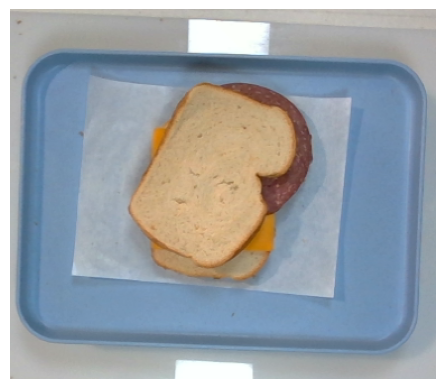

In [190]:
plt.imshow(cv2.cvtColor(second_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

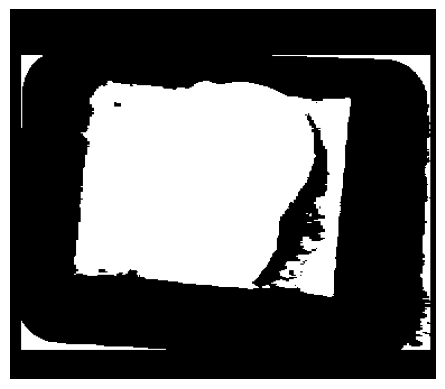

In [191]:
# Segment tray from the second image using tray HSV values
# Convert the image to HSV color space
second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
tray_hsv_lower_bound = np.array(TRAY_HSV_LOWER_BOUND, dtype=np.uint8)
tray_hsv_upper_bound = np.array(TRAY_HSV_UPPER_BOUND, dtype=np.uint8)
tray_mask = cv2.inRange(second_hsv, tray_hsv_lower_bound, tray_hsv_upper_bound)

# Invert the tray mask
tray_mask_inv = cv2.bitwise_not(tray_mask)

# Find the bounding box of the tray
contours, _ = cv2.findContours(tray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    tray_x, tray_y, tray_w, tray_h = cv2.boundingRect(largest_contour)


# Black out everything outside the tray box coordinate in tray_mask_inv
tray_mask_inv[0:tray_y+5, :] = 0
tray_mask_inv[tray_y+tray_h-5:, :] = 0
tray_mask_inv[:, 0:tray_x+5] = 0
tray_mask_inv[:, tray_x+tray_w-5:] = 0

plt.imshow(tray_mask_inv, cmap='gray')
plt.axis('off')
plt.show()

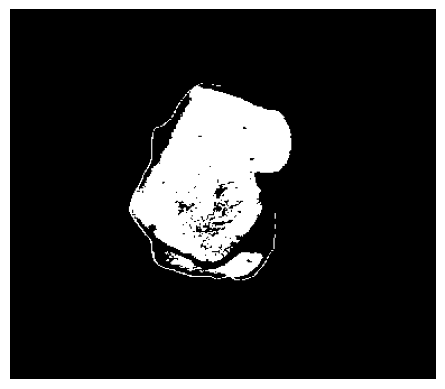

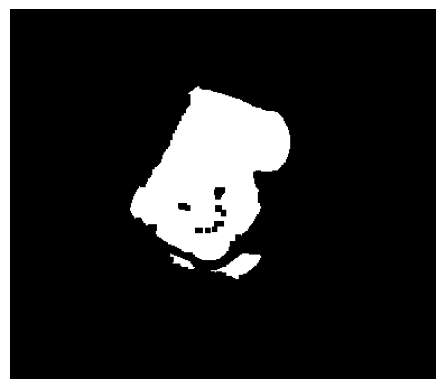

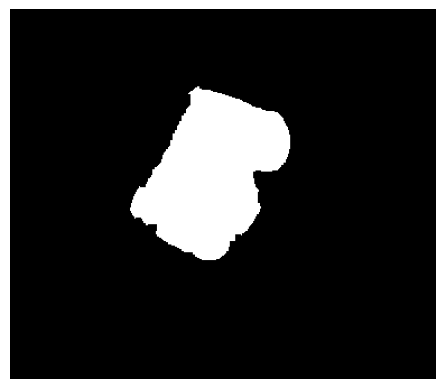

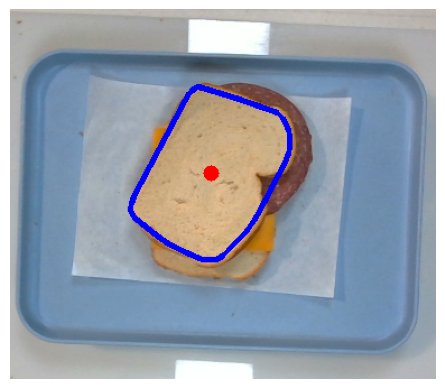

In [192]:
BREAD_HSV_LOWER_BOUND_STRICT = (10, 60, 100)
BREAD_HSV_UPPER_BOUND_STRICT = (20, 110, 220)

second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
bread_hsv_lower_bound = np.array(BREAD_HSV_LOWER_BOUND_STRICT, dtype=np.uint8)
bread_hsv_upper_bound = np.array(BREAD_HSV_UPPER_BOUND_STRICT, dtype=np.uint8)
bread_mask = cv2.inRange(second_hsv, bread_hsv_lower_bound, bread_hsv_upper_bound)

plt.imshow(bread_mask, cmap='gray')
plt.axis('off')
plt.show()

# Gaussian blur the bread mask
# bread_mask = cv2.GaussianBlur(bread_mask, (5, 5), 0)

# Erode the bread mask to remove noise
bread_mask = cv2.dilate(bread_mask, None, iterations=1)
bread_mask = cv2.erode(bread_mask, None, iterations=2)
# Dilate the bread mask to fill in gaps

plt.imshow(bread_mask, cmap='gray')
plt.axis('off')
plt.show()

# Select only the largest contour and blacken out the rest
contours, _ = cv2.findContours(bread_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:    
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    bread_mask = np.zeros_like(bread_mask)
    cv2.drawContours(bread_mask, [largest_contour], -1, 255, -1)

# Apply closing to fill in small holes
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
bread_mask = cv2.morphologyEx(bread_mask, cv2.MORPH_CLOSE, kernel)

plt.imshow(bread_mask, cmap='gray')
plt.axis('off')
plt.show()

plot_image = second_crop.copy()

# Plot the contours on the original image
contours, _ = cv2.findContours(bread_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)          
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    # cv2.drawContours(second_crop, [largest_contour], -1, (0, 255, 0), 3)

    # Find convex hull
    hull = cv2.convexHull(largest_contour)
    cv2.drawContours(plot_image, [hull], -1, (255, 0, 0), 3)

    # Find the center of the convex hull
    M = cv2.moments(hull)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    # Draw the center
    cv2.circle(plot_image, (cX, cY), 7, (0, 0, 255), -1)




plt.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [193]:
sam2_checkpoint = "/home/parth/snaak/projects/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

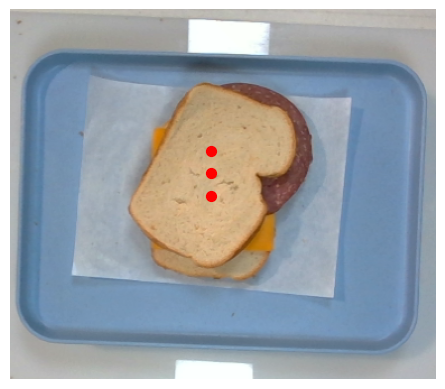

In [194]:

input_points = [[cX, cY]]

# Add two more points for prompting SAM
input_points.append([cX, cY + 20])
input_points.append([cX, cY - 20])

input_points = np.array(input_points, dtype=np.float32)
input_labels = np.array([1, 1, 1], dtype=np.int32)


predictor.set_image(second_crop)

# Plot the input points on the image using matplotlib
plt.imshow(cv2.cvtColor(second_crop, cv2.COLOR_BGR2RGB))
plt.scatter(input_points[:, 0], input_points[:, 1], color="red", s=50, label="Points")
plt.axis('off')
plt.show()

In [195]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

# show_masks(second_crop, masks, scores, point_coords=input_points, input_labels=input_labels, borders=True)

In [196]:
def select_top_bread_mask(masks):
    area_gt = 14500
    area_diff_min = 100000000
    selected_mask = None
    for i, mask in enumerate(masks):
        area_mask = np.sum(mask)
        area_diff = abs(area_mask - area_gt)
        if area_diff < area_diff_min:
            selected_mask = mask
            area_diff_min = area_diff
        print(f"Mask {i} area: {area_mask}")
    return selected_mask

def process_sam_mask(mask):
    mask_new = mask.copy()
    kernel = np.ones((5, 5), np.uint8)
    mask_new = cv2.erode(mask_new, kernel, iterations=1)
    mask_new = cv2.dilate(mask_new, kernel, iterations=1)

    # Select the largest contour and blacken out the rest
    contours, _ = cv2.findContours(mask_new, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask_new = np.zeros_like(mask_new)
        cv2.drawContours(mask_new, [largest_contour], -1, 255, -1)

    return mask_new

Mask 0 area: 17778.0
Mask 1 area: 15327.0
Mask 2 area: 20794.0


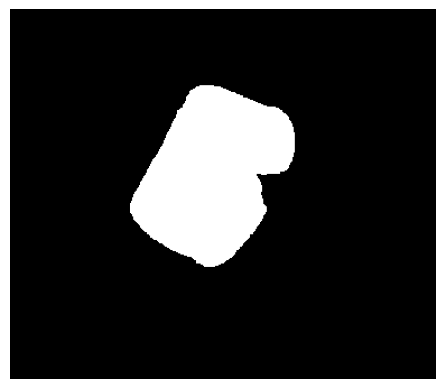

In [197]:
selected_mask = select_top_bread_mask(masks)
selected_mask = selected_mask * 255
selected_mask = selected_mask.astype(np.uint8)
selected_mask = process_sam_mask(selected_mask)


plt.imshow(selected_mask, cmap="gray")
plt.axis('off')
plt.show()

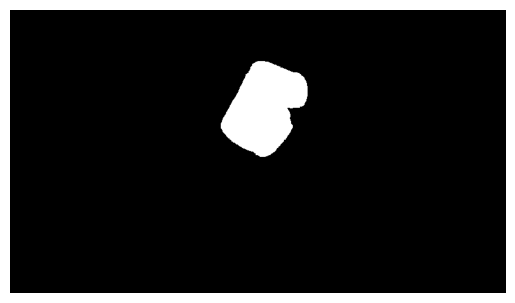

In [198]:
# Convert selected mask to original dimensions
orig_mask = convert_mask_to_orig_dims(selected_mask, second_img, TRAY_BOX_PIX[0], TRAY_BOX_PIX[1], TRAY_BOX_PIX[2], TRAY_BOX_PIX[3])
plt.imshow(orig_mask, cmap="gray")
plt.axis('off')
plt.show()

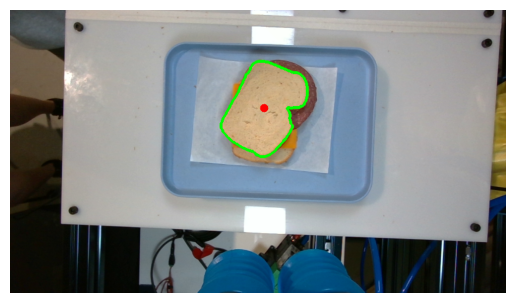

In [199]:
# Find countours in the original mask
contours, _ = cv2.findContours(orig_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plot_image = second_img.copy()
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(plot_image, [largest_contour], -1, (0, 255, 0), 3)

    # Find the center of the convex hull
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    # Draw the center
    cv2.circle(plot_image, (cX, cY), 7, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()